# Data Import 

In [51]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts

# import dataset
file_path = "C:/Users/gabri/OneDrive/Desktop/Pillitteri_Gabriele.csv"
data = pd.read_csv(file_path)

data

,obs,oil,inf,growth,pa,e,pb
0,1973M01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1973M02,-0.091286,0.201961,0.648842,-2.673726,0.401101,-0.954040
2,1973M03,-0.302287,0.115846,0.147766,-0.230488,-3.127771,-2.649218
3,1973M04,0.323823,-0.703234,0.312651,-2.776542,-11.293834,-5.393480
4,1973M05,0.236872,-0.797623,0.182704,-7.437957,-14.532341,-6.434252
...,...,...,...,...,...,...,...
395,2005M12,0.053438,-0.383117,-0.181862,351.921090,215.961986,134.724561
396,2006M01,-0.527216,-0.658755,0.178912,352.434165,207.528330,136.061288
397,2006M02,-0.317541,-0.692246,0.552441,353.692678,208.229675,135.312408
398,2006M03,0.323335,0.110545,-0.092913,351.833292,216.717093,134.828052


# Path of the variables

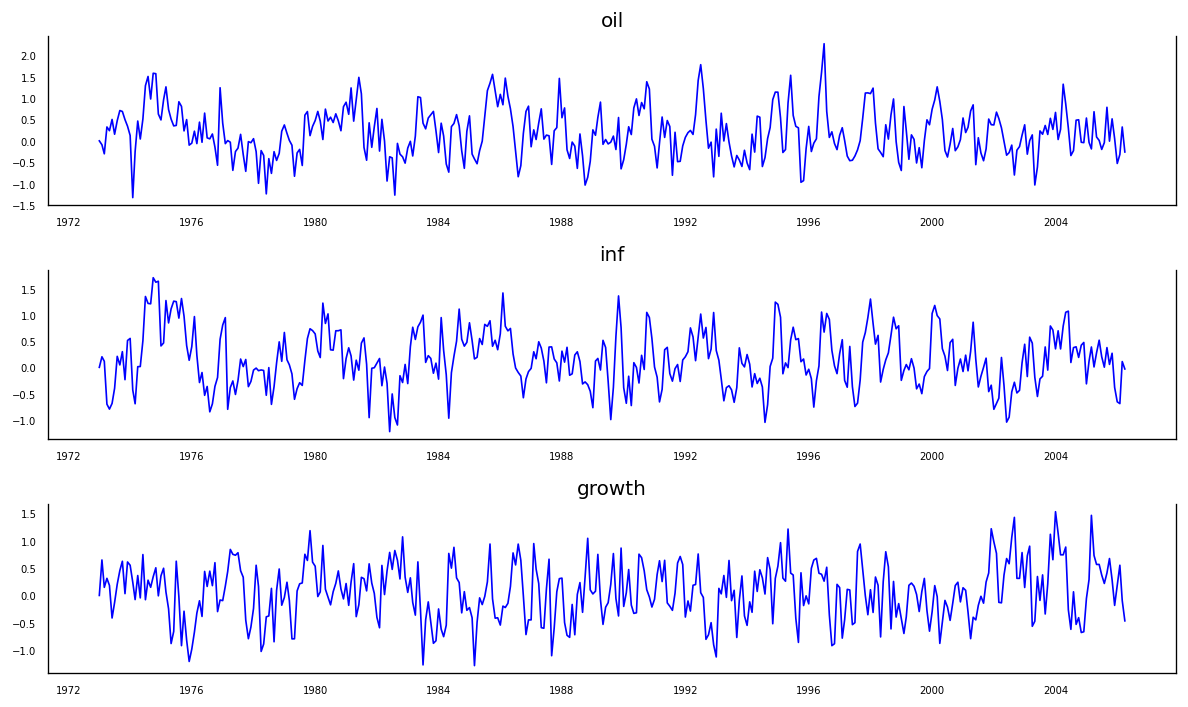

In [52]:
# Selection of the variables for the VAR model
var_data = data[["oil", "inf", "growth"]]
# Convert time format
var_data.index = pd.to_datetime(data['obs'], format='%YM%m')


fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = var_data.iloc[:, i]
    ax.plot(data, color='blue', linewidth=1)
    # Better Visualization
    ax.set_title(var_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)
plt.tight_layout()

# Stationarity Check

In [53]:
#Re-import the initial dataset
# import dataset
file_path = "C:/Users/gabri/OneDrive/Desktop/Pillitteri_Gabriele.csv"
data = pd.read_csv(file_path)
# Test Augmented Dickey-Fuller(ADF) for Stationary
adf_results = {}
for col in var_data.columns:
    result = ts.adfuller(var_data[col], autolag='AIC')
    adf_results[col] = result[1]  # p-value
for k,v in adf_results.items():
    print('ADF P-Values' +' '+ str(k) + ': ' + str(v))

ADF P-Values oil: 2.3563647641295033e-18
ADF P-Values inf: 2.8516317094373377e-15
ADF P-Values growth: 8.590786600988667e-22


# Optimal Order for sVAR and diagnostic check

In [49]:
model = VAR(var_data)
order_selection = model.select_order(maxlags = 15)
selected_order = order_selection.selected_orders
# Print the selected order
print(selected_order)

# Fit the model VAR(1) and take the residuals
var_model = model.fit(1)
residuals = var_model.resid

# Tests on the separated residuals vector
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
residual_tests = {}

for col in var_data.columns:
    res = residuals[col]
    # Ljung-Box test
    lb_pvalue = acorr_ljungbox(res, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    # ARCH test
    arch_stat, arch_pvalue, _, _ = het_arch(res)
    # Normality test (Anderson-Darling)
    ad_stat, ad_pvalue = normal_ad(res)
    # Update the results 
    residual_tests[col] = {
        "Ljung-Box Test p-value": lb_pvalue,
        "ARCH Test p-value": arch_pvalue,
        "Normality Test (Anderson-Darling) p-value": ad_pvalue
    }
residual_tests

{'aic': 1, 'bic': 1, 'hqic': 1, 'fpe': 1}


C:\Users\gabri\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'oil': {'Ljung-Box Test p-value': 0.4144144991851175,
  'ARCH Test p-value': 0.8092110460349842,
  'Normality Test (Anderson-Darling) p-value': 0.5438971629933813},
 'inf': {'Ljung-Box Test p-value': 0.9943538467752457,
  'ARCH Test p-value': 0.1470082384199402,
  'Normality Test (Anderson-Darling) p-value': 0.9141627414287896},
 'growth': {'Ljung-Box Test p-value': 0.30418182518272985,
  'ARCH Test p-value': 0.361008661503078,
  'Normality Test (Anderson-Darling) p-value': 0.7623804650788684}}

# sVAR Impulse Response Function

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 08, Feb, 2024
Time:                     15:11:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.97985
Nobs:                     399.000    HQIC:                  -5.05231
Log likelihood:          -669.056    FPE:                 0.00609786
AIC:                     -5.09982    Det(Omega_mle):      0.00591809
--------------------------------------------------------------------
Results for equation oil
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.065031         0.025123            2.589           0.010
L1.oil            0.536946         0.047328           11.345           0.000
L1.inf            0.073034         0.051078            1.430           0.153
L

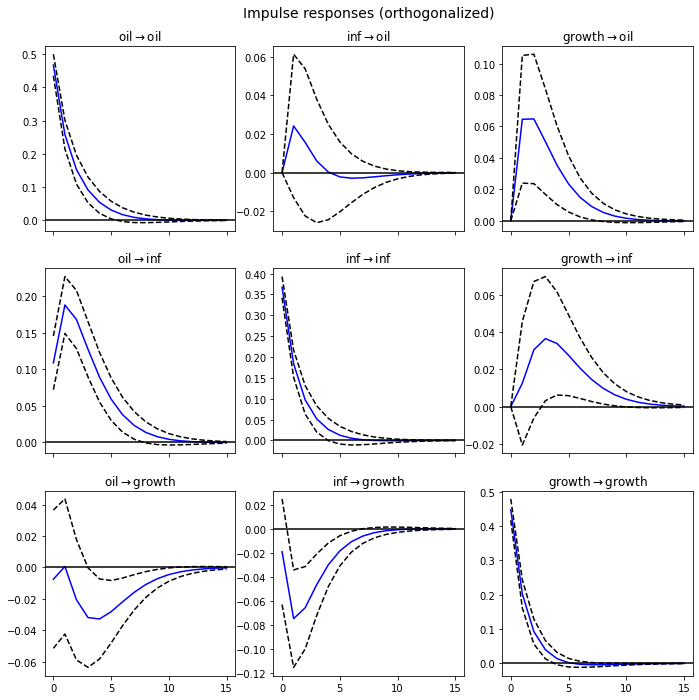

In [36]:
# Summary of the model VAR(1)
print(var_model.summary())

# calculating structural impulse response functions
irf = var_model.irf(15) #Using Choleski decomposition, where the order is OIL-INFLATION-GROWTH.

# Plot the structural impulse response functions
irf.plot(orth = True)
plt.show()

# Oil analysis - AR(I)MA Model

ARCH Test Statistic: 78.26924358532412
p-value: 1.0954306630658175e-12


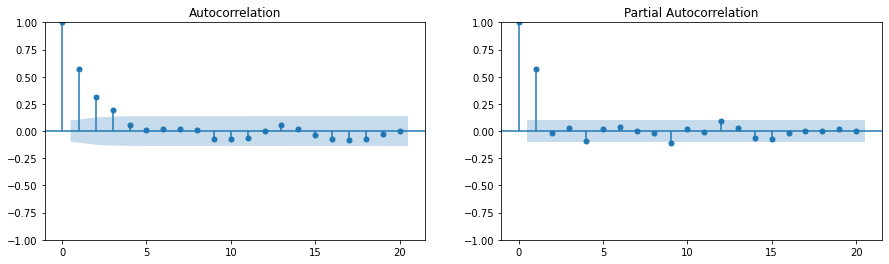

C:\Users\gabri\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\gabri\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gabri\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':             0           1           2           3
0  696.138618  569.374088  554.552531  541.968911
1  539.253097  541.072274  542.666783  541.228259
2  541.093073  542.119146  543.670819  541.561366
3  542.739448  543.471615  539.733570  538.341775, 'bic':             0           1           2           3
0  704.121547  581.348481  570.518389  561.926234
1  551.227491  557.038132  562.624105  565.177047
2  557.058931  562.076468  567.619606  569.501618
3  562.696771  567.420403  567.673822  570.273491, 'aic_min_order': (3, 3), 'bic_min_order': (1, 0)}


In [39]:
# ARMA of oil
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
import matplotlib.pyplot as plt
oil_series = data['oil']

# Check for Homoskedasticity
arch_testo = het_arch(oil_series)
print("ARCH Test Statistic:", arch_testo[0])
print("p-value:", arch_testo[1])

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
plot_acf(oil_series, lags = 20, ax = axes[0])
plot_pacf(oil_series, lags = 20, ax = axes[1])
plt.show()

# Optimal order based on information criterion
optimal_order = arma_order_select_ic(oil_series, ic=['aic', 'bic'], max_ar=3, max_ma=3)
print(optimal_order)

# Fit of the Model 

In [40]:
from statsmodels.tsa.arima.model import ARIMA

# Estimating ARMA(1,0) = ARIMA(1,0,0)
arma_model = ARIMA(oil_series, order = (1, 0, 0), trend = 'n')
arma_result = arma_model.fit()

# Summary of the model
print(arma_result.summary())

                               SARIMAX Results                                
Dep. Variable:                    oil   No. Observations:                  400
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -271.672
Date:                Thu, 08 Feb 2024   AIC                            547.345
Time:                        15:12:21   BIC                            555.328
Sample:                             0   HQIC                           550.506
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6127      0.037     16.656      0.000       0.541       0.685
sigma2         0.2275      0.016     14.018      0.000       0.196       0.259
Ljung-Box (L1) (Q):                   0.26   Jarque-